In [1]:
!pip install transformers

In [2]:
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from textwrap import wrap
from sklearn.metrics import f1_score

In [3]:
#INICIALIZARON
RANDOM_SEED = 42
MAX_LEN = 150
BATCH_SIZE = 10
NCLASSES = 3

In [4]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
df = pd.read_csv("Data_Moderador_IA_v3.csv")
print(f'Columnas: {df.columns}')
print(df)
df= df.rename(columns={'Texto': 'Text'})

Columnas: Index(['Id', 'Texto', 'Label', 'Lenguaje'], dtype='object')
        Id                                       Texto  Label Lenguaje
0        1                 "Clear and easy to follow."  clean   ingles
1        2         "Sarnosos cholos nos roban el aire"   hate  español
2        3                   "I had the same thought."  clean   ingles
3        4                          "poggers esa play"  clean  español
4        5  "¿Por qué eres tan asqueroso? Das pena. 💩"  toxic  español
...    ...                                         ...    ...      ...
2995  2996       "Filthy hoes are ruining our economy"   hate   ingles
2996  2997          "Trannies are mentally ill freaks"   hate   ingles
2997  2998                       "Gays should be shot"   hate   ingles
2998  2999  "Corrientes Argentinos váyanse a la verga"   hate  español
2999  3000                         "tu puedes crack 🙌"  clean  español

[3000 rows x 4 columns]


In [6]:
#REAJUSTE DE DATA
df['Label'] = df['Label'].map({
    'clean' : 0,
    'toxic' : 1,
    'hate' : 2
 })
df.head()

,Id,Text,Label,Lenguaje
0,1,"""Clear and easy to follow.""",0,ingles
1,2,"""Sarnosos cholos nos roban el aire""",2,español
2,3,"""I had the same thought.""",0,ingles
3,4,"""poggers esa play""",0,español
4,5,"""¿Por qué eres tan asqueroso? Das pena. 💩""",1,español


In [7]:
print(df)

        Id                                        Text  Label Lenguaje
0        1                 "Clear and easy to follow."      0   ingles
1        2         "Sarnosos cholos nos roban el aire"      2  español
2        3                   "I had the same thought."      0   ingles
3        4                          "poggers esa play"      0  español
4        5  "¿Por qué eres tan asqueroso? Das pena. 💩"      1  español
...    ...                                         ...    ...      ...
2995  2996       "Filthy hoes are ruining our economy"      2   ingles
2996  2997          "Trannies are mentally ill freaks"      2   ingles
2997  2998                       "Gays should be shot"      2   ingles
2998  2999  "Corrientes Argentinos váyanse a la verga"      2  español
2999  3000                         "tu puedes crack 🙌"      0  español

[3000 rows x 4 columns]


In [8]:
#TOKENIZACION
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [9]:
#EJEMPLO TOKENIZACION
simple_tex = "bro eres un pendejo 😴"
tokens = tokenizer.tokenize(simple_tex)
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
print('frase', simple_tex)
print('tokens', tokens)
print('tokens numericos', tokens_ids)

frase bro eres un pendejo 😴
tokens ['bro', 'ere', '##s', 'un', 'pen', '##dej', '##o', '[UNK]']
tokens numericos [93742, 14378, 10107, 10119, 66558, 90062, 10133, 100]


In [13]:
#CODIFICACION PARA INTRUDUCIR BERTH
encoding = tokenizer(
    simple_tex,
    max_length = 15,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding = 'max_length',
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [14]:
encoding.keys()

KeysView({'input_ids': tensor([[  101, 93742, 14378, 10107, 10119, 66558, 90062, 10133,   100,   102,
             0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])})

In [15]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'bro', 'ere', '##s', 'un', 'pen', '##dej', '##o', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
tensor([  101, 93742, 14378, 10107, 10119, 66558, 90062, 10133,   100,   102,
            0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])


In [24]:
class IMBDataset(Dataset):
    def __init__(self, Text, Label, tokenizer, max_len):
        self.Text = Text
        self.Label = Label
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.Text)

    def __getitem__(self, item):
        text = str(self.Text[item])
        label = self.Label[item]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'Text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [25]:
#DATA LOADER
"""
def data_loader(df_destil,tokenizer,max_len,batch_size):
  dataset = IMBDataset(
      Text = df_destil.Text.to_numpy(),
      Label = df_destil.Label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )
  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)
  """
def data_loader(df, tokenizer, max_len, batch_size):
    dataset = IMBDataset(
        Text=df.Text.to_numpy(),
        Label=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0
    )

In [26]:
#seperacion de data para las pruebas
df_train, df_temp = train_test_split(
    df,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=df['Label']
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=df_temp['Label']
)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader   = data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader  = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [27]:
print("\n=== DIAGNÓSTICO DE DATOS ===")
print(f"Total de registros: {len(df)}")
print(f"\nDistribución de clases:")
print(df['Label'].value_counts())

# Probar un batch
sample_batch = next(iter(train_data_loader))
print(f"\nForma de input_ids: {sample_batch['input_ids'].shape}")
print(f"Forma de attention_mask: {sample_batch['attention_mask'].shape}")
print(f"Forma de labels: {sample_batch['labels'].shape}")
print(f"Labels en el batch: {sample_batch['labels']}")
print(f"Ejemplo de texto: {sample_batch['Text'][0]}")


=== DIAGNÓSTICO DE DATOS ===
Total de registros: 3000

Distribución de clases:
Label
0    1200
1    1000
2     800
Name: count, dtype: int64

Forma de input_ids: torch.Size([10, 150])
Forma de attention_mask: torch.Size([10, 150])
Forma de labels: torch.Size([10])
Labels en el batch: tensor([0, 2, 1, 1, 0, 1, 1, 0, 1, 2])
Ejemplo de texto: "cuantas rondas son?"


In [28]:
class BERTModerador(nn.Module):

  def __init__(self,n_classes):
    super(BERTModerador,self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.dropout = nn.Dropout(p=0.3)
    self.linear = nn.Linear(
        self.bert.config.hidden_size,
        n_classes
    )

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.linear(x)
    return logits


In [29]:
model = BERTModerador(NCLASSES)
model = model.to(device)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [30]:
print(model)

BERTModerador(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [31]:
#ENTRENAMIENTO
EPOCHS = 10

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

# Optimizador
optimizer = AdamW(
    model.parameters(),
    lr=2e-5
)


total_steps = len(train_data_loader) * EPOCHS

# Scheduler (control del learning rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Función de pérdida
loss_fn = nn.CrossEntropyLoss().to(device)

In [32]:
#ENTRENAMIENTO BASE
def train_model(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)



In [33]:
# opcion B EVALUAR MODELO loss y f1-core Y REPORT
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            #guardar F1
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = correct_predictions.double() / n_examples
    f1 = f1_score(all_labels, all_preds, average="macro")

    return acc, np.mean(losses), f1, all_labels, all_preds #agregamos all_labels, all_preds que son necesario para el classification_report


In [34]:
#ENTRENAMIENTO!!
for epoch in range(EPOCHS):
    print('Epoch {} de {}'.format(epoch + 1, EPOCHS))
    print('--------------------')

    train_acc, train_loss = train_model(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    test_acc, test_loss, test_f1, _, _  = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
    )

    print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
    print(
        'Validación: Loss: {}, accuracy: {}, F1: {}'.format(
            test_loss, test_acc, test_f1
        )
    )
    print()

Epoch 1 de 10
--------------------
Entrenamiento: Loss: 0.3662350125122993, accuracy: 0.8680952380952381
Validación: Loss: 0.09624013868677947, accuracy: 0.9755555555555555, F1: 0.9762607103715029

Epoch 2 de 10
--------------------
Entrenamiento: Loss: 0.07283195117821119, accuracy: 0.9833333333333333
Validación: Loss: 0.11654317214464148, accuracy: 0.98, F1: 0.9799403624626496

Epoch 3 de 10
--------------------
Entrenamiento: Loss: 0.036508145848555225, accuracy: 0.9928571428571429
Validación: Loss: 0.1250105721487974, accuracy: 0.9777777777777777, F1: 0.9780765544844692

Epoch 4 de 10
--------------------
Entrenamiento: Loss: 0.02035728243548268, accuracy: 0.9966666666666667
Validación: Loss: 0.07648300816524878, accuracy: 0.9866666666666667, F1: 0.986387848946244

Epoch 5 de 10
--------------------
Entrenamiento: Loss: 0.02329279159007239, accuracy: 0.9957142857142857
Validación: Loss: 0.06105889766477048, accuracy: 0.9888888888888889, F1: 0.9884484402607091

Epoch 6 de 10
-------

In [36]:
#agregamos classification_report
from sklearn.metrics import classification_report

_, _, _, all_labels, all_preds = eval_model(
    model,
    test_data_loader, #usamos el test
    loss_fn,
    device,
    len(df_test)
)

print(classification_report(
    all_labels,
    all_preds,
    target_names=["clean", "toxic", "hate"]
    ))

              precision    recall  f1-score   support

       clean       0.99      0.99      0.99       180
       toxic       0.99      0.98      0.99       150
        hate       0.98      1.00      0.99       120

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



# **Matriz de confusión**

---



In [37]:
# Importar librerias necesarias
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [38]:
# Calcular la matriz de confusion con las predicciones que ya se obtuvieron
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[179   1   0]
 [  1 147   2]
 [  0   0 120]]


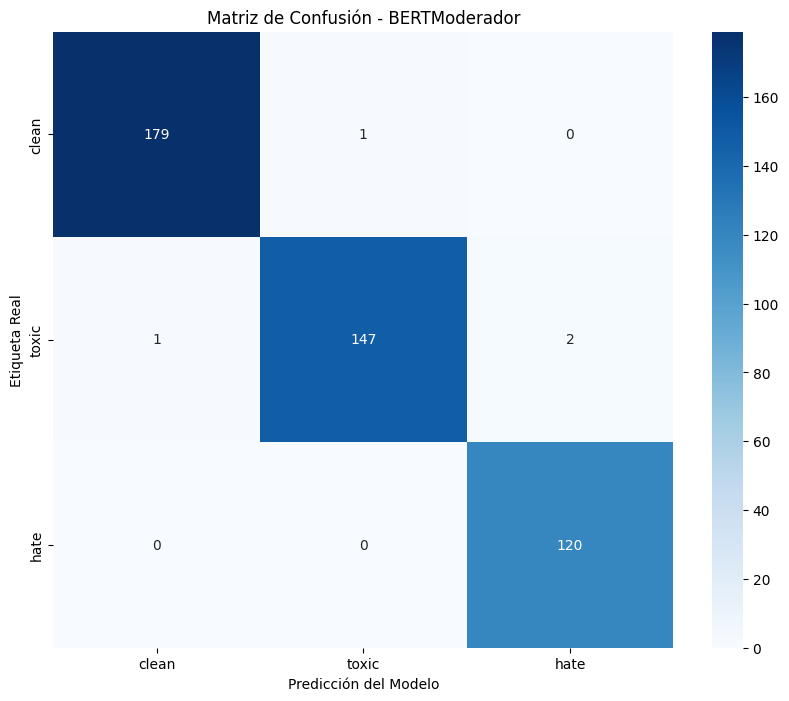

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['clean', 'toxic', 'hate'],
            yticklabels=['clean', 'toxic', 'hate'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.title('Matriz de Confusión - BERTModerador')
plt.show()

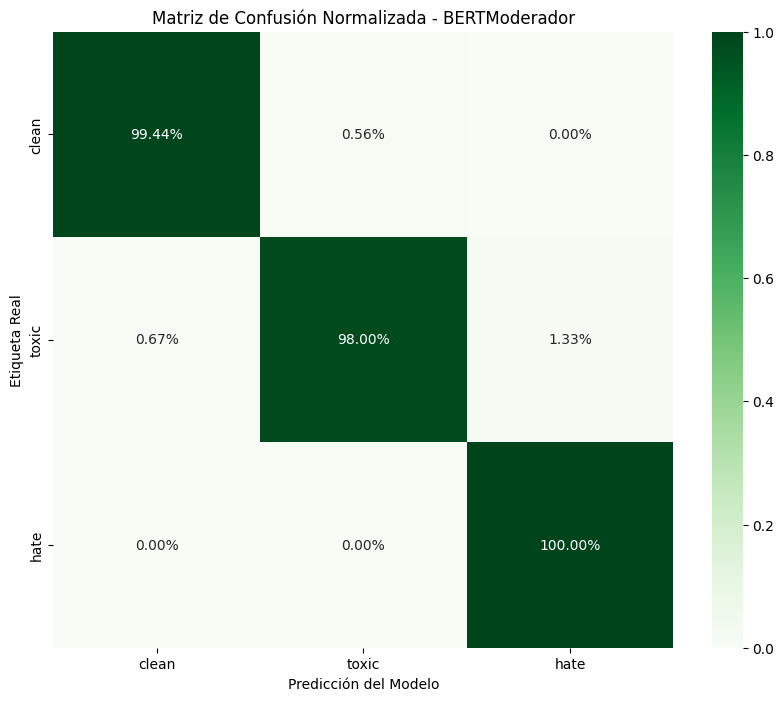

In [40]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['clean', 'toxic', 'hate'],
            yticklabels=['clean', 'toxic', 'hate'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.title('Matriz de Confusión Normalizada - BERTModerador')
plt.show()